In [1]:
try:
    import openmdao.api as om
    import dymos as dm
except ImportError:
    !python -m pip install openmdao[notebooks]
    !python -m pip install dymos[docs]
    import openmdao.api as om
    import dymos as dm

(examples:the_brachistochrone)=
# The Brachistochrone

```{admonition} Things you'll learn through this example
- How to define a basic Dymos ODE system.
- How to test the partials of your ODE system.
- Adding a Trajectory object with a single Phase to an OpenMDAO Problem.
- Imposing boundary conditions on states with simple bounds via `fix_initial` and `fix_final`.
- Using the Phase.interpolate` method to set a linear guess for state and control values across the Phase.
- Checking the validity of the result through explicit simulation via the `Trajectory.simulate` method.
```

The brachistochrone is one of the most well-known optimal control problems.
It was originally posed as a challenge by Johann Bernoulli.

```{admonition} The brachistochrone problem
_Given two points A and B in a vertical plane, find the path AMB
down which a movable point M must by virtue of its weight fall from
A to B in the shortest possible time._

-  Johann Bernoulli, Acta Eruditorum, June 1696
```

We seek to find the optimal shape of a wire between two points (A and B) such that a bead sliding
without friction along the wire moves from point A to point B in minimum time.

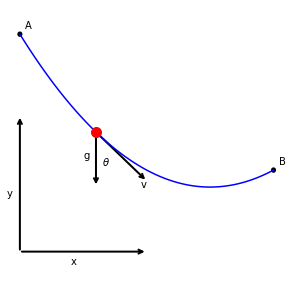

In [2]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, Arc

LW = 2

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.axis('off')

ax.set_xlim(-1, 11)
ax.set_ylim(-1, 11)

circle = plt.Circle((0, 10), radius=0.1, fc='k')
ax.add_patch(circle)
plt.text(0.2, 10.2, 'A')

circle = plt.Circle((10, 5), radius=0.1, fc='k')
ax.add_patch(circle)
plt.text(10.2, 5.2, 'B')

# Choose a to suite, compute b
a = 0.1
b = -0.5 - 10*a
c = 10

def y_wire(x):
    return a*x**2 + b*x + c, 2*a*x + b

x = np.linspace(0, 10, 100)
y, _ = y_wire(x)
plt.plot(x, y, 'b-')

# Add the bead to the wire
x = 3
y, dy_dx = y_wire(x)
plt.plot(x, y, 'ro', ms=10)

# Draw and label the gravity vector
gvec = FancyArrowPatch((x, y), (x, y-2), arrowstyle='->', mutation_scale=10, linewidth=LW, color='k')
lv_line = plt.Line2D((x, x), (y, y-2), visible=False)  # Local vertical
ax.add_patch(gvec)
plt.text(x - 0.5, y-1, 'g')

# Draw and label the velocity vector
dx = 2
dy = dy_dx * dx
vvec = FancyArrowPatch((x, y), (x+dx, y+dy), arrowstyle='->', mutation_scale=10, linewidth=LW, color='k')
ax.add_patch(vvec)
plt.text(x+dx-0.25, y+dy-0.25, 'v')

# Draw angle theta
vvec_line = plt.Line2D((x, x+dx), (y, y+dy), visible=False)
# angle_plot = get_angle_plot(lv_line, vvec_line, color='k', origin=(x, y), radius=3)
# ax.add_patch(angle_plot)
ax.text(x+0.25, y-1.25, r'$\theta$')

# Draw the axes
x = 0
y = 2
dx = 5
dy = 0
xhat = FancyArrowPatch((x, y), (x+dx, y+dy), arrowstyle='->', mutation_scale=10, linewidth=LW, color='k')
ax.add_patch(xhat)
plt.text(x+dx/2.0-0.5, y+dy/2.0-0.5, 'x')

dx = 0
dy = 5
yhat = FancyArrowPatch((x, y), (x+dx, y+dy), arrowstyle='->', mutation_scale=10, linewidth=LW, color='k')
ax.add_patch(yhat)
plt.text(x+dx/2.0-0.5, y+dy/2.0-0.5, 'y')

plt.ylim(1, 11)
plt.xlim(-0.5, 10.5)

plt.savefig('brachistochrone_fbd.png')

plt.show()

## State variables

In this implementation, three _state_ variables are used to define the configuration of the system at any given instant in time.

- **x**: The horizontal position of the particle at an instant in time.
- **y**: The vertical position of the particle at an instant in time.
- **v**: The speed of the particle at an instant in time.

## System dynamics

From the free-body diagram above, the evolution of the state variables is given by the following ordinary differential equations (ODE).

\begin{align}
    \frac{d x}{d t} &= v \sin(\theta) \\
    \frac{d y}{d t} &= -v \cos(\theta) \\
    \frac{d v}{d t} &= g \cos(\theta)
\end{align}

## Control variables

This system has a single control variable.

- **$\theta$**: The angle between the gravity vector and the tangent to the curve at the current instant in time.

## The initial and final conditions

In this case, starting point **A** is given as _(0, 10)_.
The point moving along the curve will begin there with zero initial velocity.

The initial conditions are:

\begin{align}
    x_0 &= 0 \\
    y_0 &= 10 \\
    v_0 &= 0
\end{align}

The end point **B** is given as _(10, 5)_.
The point will end there, but the velocity at that point is not constrained.

The final conditions are:

\begin{align}
    x_f &= 10 \\
    y_f &= 5 \\
    v_f &= \mathrm{free}
\end{align}

## Defining the ODE as an OpenMDAO System

In Dymos, the ODE is an OpenMDAO System (a Component, or a Group of components).
The following ExplicitComponent computes the state rates for the brachistochrone problem.

More detail on the workings of an ExplicitComponent can be found in the OpenMDAO documentation.  In summary:

- **initialize**:  Called at setup, and used to define options for the component.  **ALL** Dymos ODE components should have the property `num_nodes`, which defines the number of points at which the outputs are simultaneously computed.
- **setup**: Used to add inputs and outputs to the component, and declare which outputs (and indices of outputs) are dependent on each of the inputs.
- **compute**: Used to compute the outputs, given the inputs.
- **compute_partials**: Used to compute the derivatives of the outputs w.r.t. each of the inputs analytically.  This method may be omitted if finite difference or complex-step approximations are used, though analytic is recommended.

In [3]:
import numpy as np
import openmdao.api as om


class BrachistochroneODE(om.ExplicitComponent):

    def initialize(self):
        self.options.declare('num_nodes', types=int)
        self.options.declare('static_gravity', types=(bool,), default=False,
                             desc='If True, treat gravity as a static (scalar) input, rather than '
                                  'having different values at each node.')

    def setup(self):
        nn = self.options['num_nodes']

        # Inputs
        self.add_input('v', val=np.zeros(nn), desc='velocity', units='m/s')

        if self.options['static_gravity']:
            self.add_input('g', val=9.80665, desc='grav. acceleration', units='m/s/s',
                           tags=['dymos.static_target'])
        else:
            self.add_input('g', val=9.80665 * np.ones(nn), desc='grav. acceleration', units='m/s/s')

        self.add_input('theta', val=np.ones(nn), desc='angle of wire', units='rad')

        self.add_output('xdot', val=np.zeros(nn), desc='velocity component in x', units='m/s',
                        tags=['dymos.state_rate_source:x', 'dymos.state_units:m'])

        self.add_output('ydot', val=np.zeros(nn), desc='velocity component in y', units='m/s',
                        tags=['dymos.state_rate_source:y', 'dymos.state_units:m'])

        self.add_output('vdot', val=np.zeros(nn), desc='acceleration magnitude', units='m/s**2',
                        tags=['dymos.state_rate_source:v', 'dymos.state_units:m/s'])

        self.add_output('check', val=np.zeros(nn), desc='check solution: v/sin(theta) = constant',
                        units='m/s')

        # Setup partials
        arange = np.arange(self.options['num_nodes'])
        self.declare_partials(of='vdot', wrt='theta', rows=arange, cols=arange)

        self.declare_partials(of='xdot', wrt='v', rows=arange, cols=arange)
        self.declare_partials(of='xdot', wrt='theta', rows=arange, cols=arange)

        self.declare_partials(of='ydot', wrt='v', rows=arange, cols=arange)
        self.declare_partials(of='ydot', wrt='theta', rows=arange, cols=arange)

        self.declare_partials(of='check', wrt='v', rows=arange, cols=arange)
        self.declare_partials(of='check', wrt='theta', rows=arange, cols=arange)

        if self.options['static_gravity']:
            c = np.zeros(self.options['num_nodes'])
            self.declare_partials(of='vdot', wrt='g', rows=arange, cols=c)
        else:
            self.declare_partials(of='vdot', wrt='g', rows=arange, cols=arange)

    def compute(self, inputs, outputs):
        theta = inputs['theta']
        cos_theta = np.cos(theta)
        sin_theta = np.sin(theta)
        g = inputs['g']
        v = inputs['v']

        outputs['vdot'] = g * cos_theta
        outputs['xdot'] = v * sin_theta
        outputs['ydot'] = -v * cos_theta
        outputs['check'] = v / sin_theta

    def compute_partials(self, inputs, partials):
        theta = inputs['theta']
        cos_theta = np.cos(theta)
        sin_theta = np.sin(theta)
        g = inputs['g']
        v = inputs['v']

        partials['vdot', 'g'] = cos_theta
        partials['vdot', 'theta'] = -g * sin_theta

        partials['xdot', 'v'] = sin_theta
        partials['xdot', 'theta'] = v * cos_theta

        partials['ydot', 'v'] = -cos_theta
        partials['ydot', 'theta'] = v * sin_theta

        partials['check', 'v'] = 1 / sin_theta
        partials['check', 'theta'] = -v * cos_theta / sin_theta ** 2

```{admonition} "Things to note about the ODE system"
- There is no input for the position states ($x$ and $y$).  The dynamics aren't functions of these states, so they aren't needed as inputs.
- While $g$ is an input to the system, since it will never change throughout the trajectory, it can be an option on the system.  This way we don't have to define any partials w.r.t. $g$.
- The output `check` is an _auxiliary_ output, not a rate of the state variables.  In this case, optimal control theory tells us that `check` should be constant throughout the trajectory, so it's a useful output from the ODE.
```

## Testing the ODE

Now that the ODE system is defined, it is strongly recommended to test the analytic partials before using it in optimization.
If the partials are incorrect, then the optimization will almost certainly fail.
Fortunately, OpenMDAO makes testing derivatives easy with the `check_partials` method.
The `assert_check_partials` method in `openmdao.utils.assert_utils` can be used in test frameworks to verify the correctness of the partial derivatives in a model.

The following is a test method which creates a new OpenMDAO problem whose model contains the ODE class.
The problem is setup with the `force_alloc_complex=True` argument to enable complex-step approximation of the derivatives.
Complex step typically produces derivative approximations with an error on the order of 1.0E-16, as opposed to ~1.0E-6 for forward finite difference approximations.

In [4]:
import numpy as np
import openmdao.api as om

num_nodes = 5

p = om.Problem(model=om.Group())

ivc = p.model.add_subsystem('vars', om.IndepVarComp())
ivc.add_output('v', shape=(num_nodes,), units='m/s')
ivc.add_output('theta', shape=(num_nodes,), units='deg')

p.model.add_subsystem('ode', BrachistochroneODE(num_nodes=num_nodes))

p.model.connect('vars.v', 'ode.v')
p.model.connect('vars.theta', 'ode.theta')

p.setup(force_alloc_complex=True)

p.set_val('vars.v', 10*np.random.random(num_nodes))
p.set_val('vars.theta', 10*np.random.uniform(1, 179, num_nodes))

p.run_model()
cpd = p.check_partials(method='cs', compact_print=True)

-----------------------------------
Component: BrachistochroneODE 'ode'
-----------------------------------
'<output>' wrt '<variable>' | calc mag.  | check mag. | a(cal-chk) | r(cal-chk)
-------------------------------------------------------------------------------

'check'    wrt 'g'          | 0.0000e+00 | 0.0000e+00 | 0.0000e+00 | nan
'check'    wrt 'theta'      | 5.4636e+01 | 5.4636e+01 | 3.8459e-16 | 7.0391e-18
'check'    wrt 'v'          | 3.7203e+00 | 3.7203e+00 | 2.2204e-16 | 5.9684e-17
'vdot'     wrt 'g'          | 1.2766e+00 | 1.2766e+00 | 1.5701e-16 | 1.2299e-16
'vdot'     wrt 'theta'      | 1.8003e+01 | 1.8003e+01 | 1.9860e-15 | 1.1031e-16
'vdot'     wrt 'v'          | 0.0000e+00 | 0.0000e+00 | 0.0000e+00 | nan
'xdot'     wrt 'g'          | 0.0000e+00 | 0.0000e+00 | 0.0000e+00 | nan
'xdot'     wrt 'theta'      | 6.7720e+00 | 6.7720e+00 | 8.8818e-16 | 1.3115e-16
'xdot'     wrt 'v'          | 1.8358e+00 | 1.8358e+00 | 1.9230e-16 | 1.0475e-16
'ydot'     wrt 'g'          | 0.

In [5]:
from dymos.utils.testing_utils import assert_check_partials

assert_check_partials(cpd)

## Solving the problem with Legendre-Gauss-Lobatto collocation in Dymos

The following script fully defines the brachistochrone problem with Dymos and solves it.  In this section we'll walk through each step.

In [6]:
import openmdao.api as om
import dymos as dm
from dymos.examples.plotting import plot_results
from dymos.examples.brachistochrone import BrachistochroneODE
import matplotlib.pyplot as plt

#
# Initialize the Problem and the optimization driver
#
p = om.Problem(model=om.Group())
p.driver = om.ScipyOptimizeDriver()
p.driver.declare_coloring()

#
# Create a trajectory and add a phase to it
#
traj = p.model.add_subsystem('traj', dm.Trajectory())

phase = traj.add_phase('phase0',
                       dm.Phase(ode_class=BrachistochroneODE,
                                transcription=dm.GaussLobatto(num_segments=10)))

#
# Set the variables
#
phase.set_time_options(fix_initial=True, duration_bounds=(.5, 10))

phase.add_state('x', fix_initial=True, fix_final=True)

phase.add_state('y', fix_initial=True, fix_final=True)

phase.add_state('v', fix_initial=True, fix_final=False)

phase.add_control('theta', continuity=True, rate_continuity=True,
                  units='deg', lower=0.01, upper=179.9)

phase.add_parameter('g', units='m/s**2', val=9.80665)

#
# Minimize time at the end of the phase
#
phase.add_objective('time', loc='final', scaler=10)

p.model.linear_solver = om.DirectSolver()

#
# Setup the Problem
#
p.setup()

#
# Set the initial values
#
p['traj.phase0.t_initial'] = 0.0
p['traj.phase0.t_duration'] = 2.0

p.set_val('traj.phase0.states:x', phase.interp('x', ys=[0, 10]))
p.set_val('traj.phase0.states:y', phase.interp('y', ys=[10, 5]))
p.set_val('traj.phase0.states:v', phase.interp('v', ys=[0, 9.9]))
p.set_val('traj.phase0.controls:theta', phase.interp('theta', ys=[5, 100.5]))

#
# Solve for the optimal trajectory
#
dm.run_problem(p)

# Check the results
print(p.get_val('traj.phase0.timeseries.time')[-1])


--- Constraint Report [traj] ---
    --- phase0 ---
        None

Model viewer data has already has already been recorded for Driver.
Full total jacobian was computed 3 times, taking 0.026083 seconds.
Total jacobian shape: (40, 50) 


Jacobian shape: (40, 50)  (18.15% nonzero)
FWD solves: 13   REV solves: 0
Total colors vs. total size: 13 vs 50  (74.0% improvement)

Sparsity computed using tolerance: 1e-25
Time to compute sparsity: 0.026083 sec.
Time to compute coloring: 0.039141 sec.


/Users/rfalck/Codes/OpenMDAO.git/openmdao/core/system.py:1913: PromotionWarning:'traj.phases.phase0.continuity_comp' <class GaussLobattoContinuityComp>: input variable 't_duration', promoted using 't_duration', was already promoted using 't_duration'.
/Users/rfalck/Codes/OpenMDAO.git/openmdao/recorders/sqlite_recorder.py:223: UserWarning:The existing case recorder file, dymos_solution.db, is being overwritten.


Optimization terminated successfully    (Exit mode 0)
            Current function value: [18.0161673]
            Iterations: 24
            Function evaluations: 24
            Gradient evaluations: 24
Optimization Complete
-----------------------------------
[1.80161673]


In [7]:
from openmdao.utils.assert_utils import assert_near_equal

assert_near_equal(p.get_val('traj.phase0.timeseries.time')[-1], 1.8016, tolerance=1.0E-3)

9.286447509678318e-06


Simulating trajectory traj
Done simulating trajectory traj


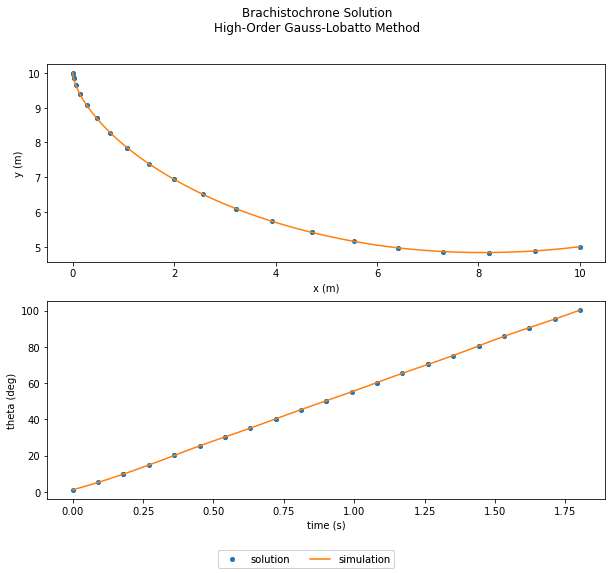

In [8]:
# Generate the explicitly simulated trajectory
exp_out = traj.simulate()

plot_results([('traj.phase0.timeseries.states:x', 'traj.phase0.timeseries.states:y',
               'x (m)', 'y (m)'),
              ('traj.phase0.timeseries.time', 'traj.phase0.timeseries.controls:theta',
               'time (s)', 'theta (deg)')],
             title='Brachistochrone Solution\nHigh-Order Gauss-Lobatto Method',
             p_sol=p, p_sim=exp_out)

plt.show()

(examples:brachistochrone:explicit_shooting)=
## Solving the problem with single shooting in Dymos

The following script fully defines the brachistochrone problem with Dymos and solves it using a single explicit shooting method.

The code is nearly identical to that using the collocation approach.
Key differences are shown when defining the transcription, specifying how to constraint the final state values of `x` and `y` states, and providing initial guesses for all states.

In [16]:
import openmdao.api as om
import dymos as dm
from dymos.examples.plotting import plot_results
from dymos.examples.brachistochrone import BrachistochroneODE
import matplotlib.pyplot as plt

#
# Initialize the Problem and the optimization driver
#
p = om.Problem(model=om.Group())
p.driver = om.ScipyOptimizeDriver()

# We'll try to use coloring, but OpenMDAO will tell us that it provides no benefit.
p.driver.declare_coloring()

#
# Create a trajectory and add a phase to it
#
traj = p.model.add_subsystem('traj', dm.Trajectory())

phase = traj.add_phase('phase0',
                       dm.Phase(ode_class=BrachistochroneODE,
                                transcription=dm.ExplicitShooting(num_segments=10,
                                                                  num_steps_per_segment=10,
                                                                  method='rk4')))

#
# Set the variables
#
phase.set_time_options(fix_initial=True, duration_bounds=(.5, 10))

# Note, we cannot use fix_final=True with the shooting method
# because the final value of the states are 
# not design variables in the transcribed optimization problem.
phase.add_state('x', fix_initial=True)

phase.add_state('y', fix_initial=True)

phase.add_state('v', fix_initial=True)

phase.add_control('theta', continuity=True, rate_continuity=True,
                  units='deg', lower=0.01, upper=179.9)

phase.add_parameter('g', units='m/s**2', val=9.80665)

#
# Minimize time at the end of the phase
#
phase.add_objective('time', loc='final', scaler=10)

#
# Add boundary constraints for x and y since we could not use `fix_final=True` 
#
phase.add_boundary_constraint('x', loc='final', equals=10)
phase.add_boundary_constraint('y', loc='final', equals=5)

p.model.linear_solver = om.DirectSolver()

#
# Setup the Problem
#
p.setup()

#
# Set the initial values
#
p['traj.phase0.t_initial'] = 0.0
p['traj.phase0.t_duration'] = 2.0

# Only the initial values of the states are design variables,
# so the phase interp method is not used on states.
p.set_val('traj.phase0.states:x', 0.0)
p.set_val('traj.phase0.states:y', 10.0)
p.set_val('traj.phase0.states:v', 0.0)
p.set_val('traj.phase0.controls:theta', phase.interp('theta', ys=[5, 100.5]))

#
# Solve for the optimal trajectory
#
dm.run_problem(p)

# Check the results
print(p.get_val('traj.phase0.timeseries.time')[-1])


--- Constraint Report [traj] ---
    --- phase0 ---
        [final]   1.0000e+01 m    == x
        [final]   5.0000e+00 m    == y

Model viewer data has already has already been recorded for Driver.


/Users/rfalck/Codes/OpenMDAO.git/openmdao/recorders/sqlite_recorder.py:223: UserWarning:The existing case recorder file, dymos_solution.db, is being overwritten.


Full total jacobian was computed 3 times, taking 0.008313 seconds.
Total jacobian shape: (12, 22) 


Jacobian shape: (12, 22)  (100.00% nonzero)
FWD solves: 0   REV solves: 12
Total colors vs. total size: 12 vs 12  (0.0% improvement)

Sparsity computed using tolerance: 1e-25
Time to compute sparsity: 0.008313 sec.
Time to compute coloring: 0.013660 sec.


/Users/rfalck/Codes/OpenMDAO.git/openmdao/drivers/scipy_optimizer.py:439: DerivativesWarning:ScipyOptimizeDriver: Coloring was deactivated.  Improvement of 0.0% was less than min allowed (5.0%).


Optimization terminated successfully    (Exit mode 0)
            Current function value: [18.01647189]
            Iterations: 11
            Function evaluations: 13
            Gradient evaluations: 11
Optimization Complete
-----------------------------------
[1.80164719]


In [17]:
assert_near_equal(p.get_val('traj.phase0.timeseries.time')[-1], 1.8016, tolerance=1.0E-3)

2.6193072688235034e-05

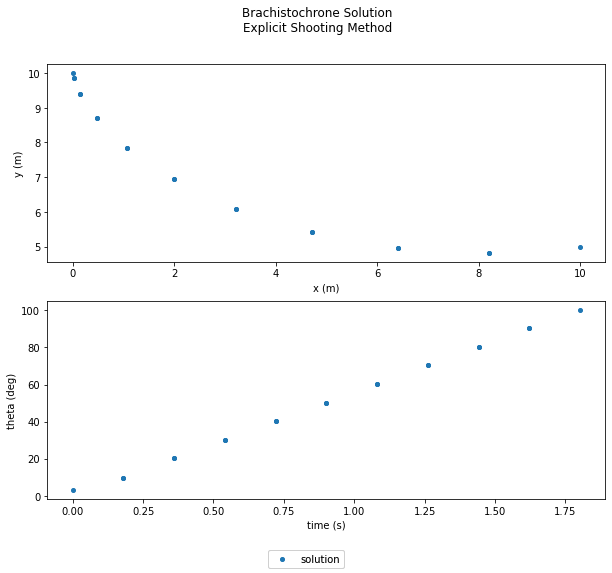

In [19]:
plot_results([('traj.phase0.timeseries.states:x', 'traj.phase0.timeseries.states:y',
               'x (m)', 'y (m)'),
              ('traj.phase0.timeseries.time', 'traj.phase0.timeseries.controls:theta',
               'time (s)', 'theta (deg)')],
             title='Brachistochrone Solution\nExplicit Shooting Method',
             p_sol=p)

plt.show()

Note that the shooting methods provide timeseries values at the start and end of each segment.
Due to plans to enable variable step integration in the future, Dymos cannot provide outputs for each individual step since the number of steps will not be known when setting up the problem.

Because control values and rates may not be continuous across segment bounds, depending on the settings used, there may be discontinuities in ODE outputs and therefore timeseries values are provided on each side of each segment boundary.